# SECTION 1: Setting Up

## 1A. Importing Libraries

The following two code chunks install and import the required libraries. Uncomment the code if you are using google colab. Otherwise, the required libraries are specified in the requirement.txt file.


In [ ]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install matplotlib-venn
# %pip install seaborn
# %pip install missingno
# %pip install scikit-learn
# %pip install scipy
# %pip install imbalanced-learn
# %pip install xgboost

In [ ]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import missingno as msno

# Statistical analysis
import scipy.stats as stats

# Machine learning utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from xgboost import XGBClassifier

## 1B: Importing Data

To ensure compatibility across different environments, if you're running locally, upload the dataset into the project folder. Otherwise, if you're using Google Colab, upload it into the "content" folder. After uploading, the following code will read the file and display basic information about the dataset.


In [ ]:
data = pd.read_csv("Champions_Group_2025.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   LATITUDE                             29062 non-null  float64
 1   LONGITUDE                            29062 non-null  float64
 2   AccountID                            29182 non-null  object 
 3   Company                              29182 non-null  object 
 4   SIC Code                             29182 non-null  int64  
 5   Industry                             29182 non-null  object 
 6   8-Digit SIC Code                     29182 non-null  int64  
 7   8-Digit SIC Description              29182 non-null  object 
 8   Year Found                           28748 non-null  float64
 9   Parent Company                       28668 non-null  object 
 10  Parent Country                       28662 non-null  object 
 11  Ownership Type              

## 1C: Defining Target Variable

To visualize the relationship between Domestic Ultimate and Global Ultimate, we plotted a Venn Diagram. Our analysis showed that `Is Domestic Ultimate` is a subset of `Is Global Ultimate`. Under the assumption that all Global Ultimates must also be Domestic Ultimates, we merged these two binary columns into a single multiclass classification target variable, `Ultimate_Status`, to simplify the problem.

The new target column, Ultimate_Status, is defined as follows:
- `0`: Neither Domestic nor Global Ultimate
- `1`: Domestic Ultimate but not Global Ultimate
- `2`: Both Domestic & Global Ultimate  

A pie chart of Ultimate_Status reveals that the response classes are relatively balanced, with a 2:1:1 distribution across the three categories. The balanced representation of the classes indicates that the model will have a reasonable amount of training data for each category, reducing the risk of bias toward a dominant class. However, class weighting or resampling techniques might still be considered if performance disparities arise during modeling.

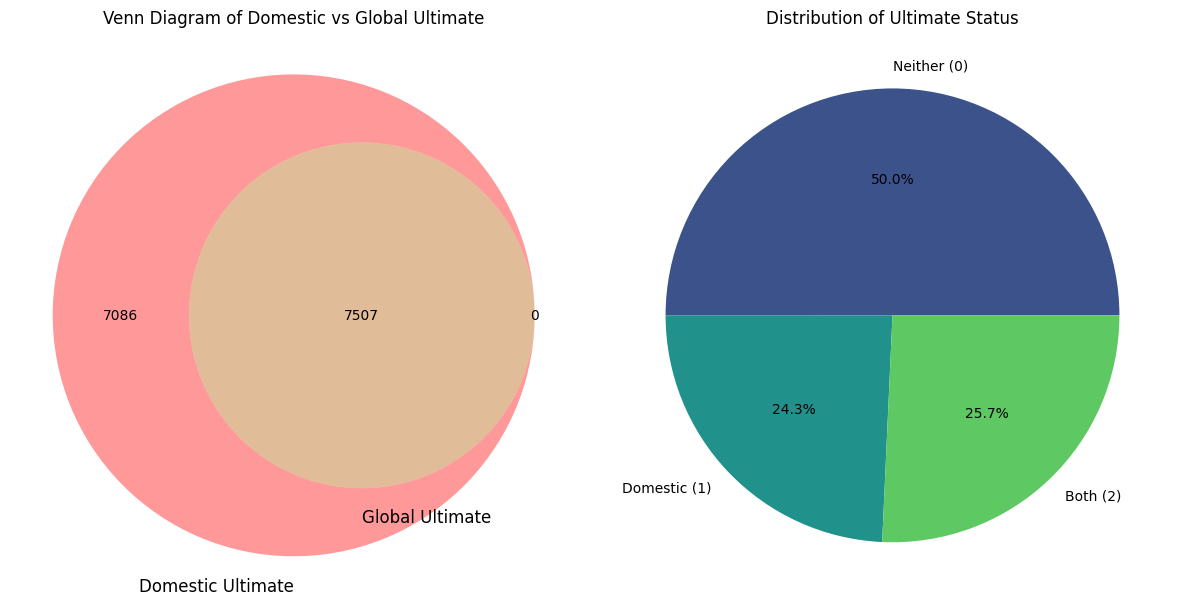

In [ ]:
# Extract counts for Venn Diagram
both_ultimate = ((data["Is Domestic Ultimate"] == 1) & (data["Is Global Ultimate"] == 1)).sum()
domestic_ultimate = data["Is Domestic Ultimate"].sum() - both_ultimate
global_ultimate = data["Is Global Ultimate"].sum() - both_ultimate

# Create multiclass target variable
data["Ultimate_Status"] = data["Is Domestic Ultimate"] + data["Is Global Ultimate"]

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Venn Diagram on the left
venn2(subsets=(domestic_ultimate, global_ultimate, both_ultimate),
      set_labels=("Domestic Ultimate", "Global Ultimate"), ax=axes[0])
axes[0].set_title("Venn Diagram of Domestic vs Global Ultimate")

# Plot Pie Chart on the right
data["Ultimate_Status"].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%', colors=sns.color_palette("viridis", 3),
    labels=["Neither (0)", "Domestic (1)", "Both (2)"], ax=axes[1]
)
axes[1].set_title("Distribution of Ultimate Status")
axes[1].set_ylabel("")  # Hide y-axis label for better aesthetics

# Show the plots
plt.tight_layout()
plt.show()

# SECTION 2: DATA CLEANING

This section involves **data cleaning, imputation, and outlier removal** to prepare the dataset for further analysis and feature engineering.  

At the end of this section, the cleaned dataset **`data_clean`** will be used for EDA and feature engineering.


In [ ]:
data_clean = data.copy()

## 2A. Marking Irrelevant Columns for Removal

A cursory analysis of the dataset structure and missing value distribution led us to mark the following columns for removal. We will finalize the removal at the end of data cleaning.

- **Geographic Data**: `LATITUDE` `LONGITUDE` (Unlikely to predict corporate classification as all the coordinates correspond to Singapore)
- **Industry Codes**: `8-Digit SIC Code` `8-Digit SIC Description` `Industry` (Will retain `SIC Code` instead to determine industry sector)
- **High Cardinality**: `AccountID` `Company` `Company Description`
- **Excessive Missing Data**: `Square Footage` `Fiscal Year End`
- **Low Variance**: `Company Status (Active/Inactive)` (Only one unique value)
- **Excluded as per Instructions**: `Parent Country` `Parent Company`


In [ ]:
# Basic Summary of Columns
data.describe(include='all')

,LATITUDE,LONGITUDE,AccountID,Company,SIC Code,Industry,8-Digit SIC Code,8-Digit SIC Description,Year Found,Parent Company,...,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Fiscal Year End,Is Domestic Ultimate,Is Global Ultimate,Ultimate_Status
count,29062.000000,29062.000000,29182,29182,29182.000000,29182,2.918200e+04,29182,28748.000000,28668,...,16779.000000,29103.000000,2.640800e+04,2.918200e+04,2.918200e+04,6613,6737,29182.000000,29182.000000,29182.000000
unique,NaN,NaN,29182,29182,NaN,580,NaN,2191,NaN,17882,...,NaN,NaN,NaN,NaN,NaN,3,115,NaN,NaN,NaN
top,NaN,NaN,LAKB2BID143135,ALLIED SPECIALTY COMPOUNDS PTE LTD,NaN,"Offices of Holding Companies, Not Elsewhere Cl...",NaN,"Holding companies, nec",NaN,GIC (VENTURES) PTE. LTD.,...,NaN,NaN,NaN,NaN,NaN,Both Imports & Exports,2021-12-31T05:00:00Z,NaN,NaN,NaN
freq,NaN,NaN,1,1,NaN,7753,NaN,6490,NaN,288,...,NaN,NaN,NaN,NaN,NaN,4254,1959,NaN,NaN,NaN
mean,1.320677,103.843324,NaN,NaN,6169.271160,NaN,6.169092e+07,NaN,2004.505913,NaN,...,36.856189,139.764182,6.994665e+03,7.520992e+08,3.931771e+09,NaN,NaN,0.500069,0.257248,0.757316
std,0.043740,0.053757,NaN,NaN,1705.845535,NaN,1.705778e+07,NaN,13.464238,NaN,...,173.334420,1118.939249,4.539462e+04,1.019636e+10,2.184589e+10,NaN,NaN,0.500009,0.437125,0.835648
min,1.238792,103.611319,NaN,NaN,132.000000,NaN,1.320000e+06,NaN,1819.000000,NaN,...,1.000000,1.000000,1.000000e+00,-1.502631e+08,1.000000e+00,NaN,NaN,0.000000,0.000000,0.000000
25%,1.284665,103.831874,NaN,NaN,5084.000000,NaN,5.084000e+07,NaN,1997.000000,NaN,...,10.000000,4.000000,4.000000e+00,1.026308e+06,1.026308e+06,NaN,NaN,0.000000,0.000000,0.000000
50%,1.309701,103.848989,NaN,NaN,6719.000000,NaN,6.719000e+07,NaN,2008.000000,NaN,...,16.000000,16.000000,1.500000e+01,2.606644e+06,3.259582e+06,NaN,NaN,1.000000,0.000000,1.000000
75%,1.337889,103.865922,NaN,NaN,7311.000000,NaN,7.311000e+07,NaN,2014.000000,NaN,...,29.000000,60.000000,1.000000e+02,2.176969e+07,1.482258e+08,NaN,NaN,1.000000,1.000000,2.000000


<ipython-input-7-fed9675eac41>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_report.values, y=missing_report.index, palette="viridis")


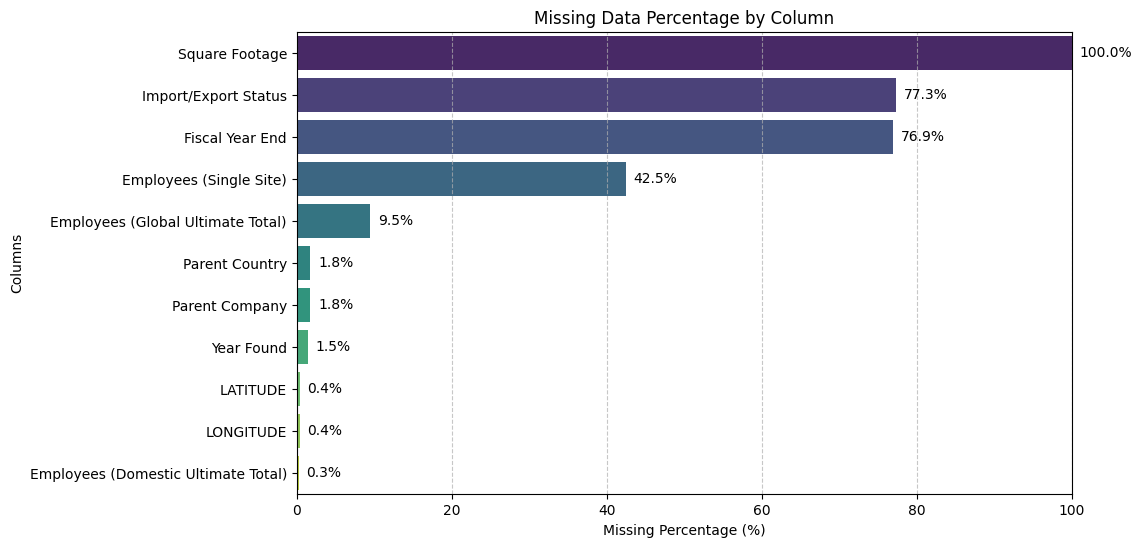

In [ ]:
# Calculate missing percentage
missing_report = data.isnull().mean() * 100

# Filter out non-missing columns
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)

# Plot missing data as a bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=missing_report.values, y=missing_report.index, palette="viridis")

# Annotate each bar with the percentage value
for i, v in enumerate(missing_report.values):
    ax.text(v + 1, i, f"{v:.1f}%", va="center", fontsize=10)

# Labels and title
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Columns")
plt.title("Missing Data Percentage by Column")
plt.xlim(0, 100)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Specifying columns to drop
columns_dropped = [
    "LATITUDE", "LONGITUDE",  # Geolocation, unlikely to be predictive
    "8-Digit SIC Code", "8-Digit SIC Description", "Industry",  # Will use SIC Code instead
    "AccountID", "Company", "Company Description",  # High cardinality
    "Square Footage", "Fiscal Year End",  # >75% missing data
    "Company Status (Active/Inactive)",  # Only 1 unique value
    "Parent Company", "Parent Country",  # Excluded as per instructions
    "Is Domestic Ultimate", "Is Global Ultimate" # Replaced with Ultimate Status
]

# The columns noted here (columns_dropped) will be dropped in section 2F

## 2B. Handling Missing Values

From prior analysis, missing values were found in:
- `Import/Export Status` (77.3%)
- `Employees (Single Site)` (42.5%)
- `Employees` (Global Ultimate Total) (9.5% missing)
- `Year Found` (1.49% missing)
- `Employees` (Domestic Ultimate Total) (0.27% missing)

After analyzing the possible values for `Import/Export Status`, we observed that missing values likely correspond to companies that do not engage in international trade. To maintain consistency with existing categories, we imputed these missing values with "Neither", indicating that the company operates solely within the domestic market.

In [ ]:
# Investigating Values for Import/Export Status
print(data_clean["Import/Export Status"].value_counts(dropna=False))

# Impute missing values in 'Import/Export Status' with "Neither"
data_clean["Import/Export Status"] = data_clean["Import/Export Status"].replace(np.nan, "Neither")

Import/Export Status
NaN                       22569
Both Imports & Exports     4254
Exports                    1681
Imports                     678
Name: count, dtype: int64


For `Employees (Single Site)`, we observed that companies with recorded values (i.e., non-missing data) were highly unlikely to be classified as Global Ultimates. This suggests that having employees at a single site is more common for domestic companies or subsidiaries, while Global Ultimates typically operate across multiple locations.

To capture this pattern, we created a binary flag, `missing_single_employees`, indicating whether the value was originally missing. Additionally, to maintain numerical stability and avoid potential issues with logarithmic transformations or division by zero, we imputed missing values as 1 instead of 0. This assumption ensures that each company is considered to have at least one employee at its primary site while preserving the overall distribution of recorded values.

In [ ]:
# Subset data where "Employees (Single Site)" is NOT missing (before imputation)
non_missing_single_employees = data_clean[data_clean["Employees (Single Site)"].notna()]

# Generate a table showing the distribution of 'Ultimate Status' for non-missing values
print("Proportion of Ultimate Status in Companies WITHOUT Missing Global Employees")
print(non_missing_single_employees["Ultimate_Status"].value_counts(normalize=True))

# Create a binary flag for companies that have recorded employees at a single site
data_clean["missing_single_employees"] = data_clean["Employees (Single Site)"].isna().astype(int)

# Impute missing values as 0, assuming these companies do not have employees at a single site
data_clean["Employees (Single Site)"] = data_clean["Employees (Single Site)"].replace(np.nan, 1)

Proportion of Ultimate Status in Companies WITHOUT Missing Global Employees
Ultimate_Status
0    0.688182
1    0.305024
2    0.006794
Name: proportion, dtype: float64


A similar imputation strategy was applied to `Employees (Global Ultimate Total)` where missing values were associated with a very low chanve of being a Global Ultimate. We created a binary flag, `missing_global_employees`, to capture the pattern of missing values and imputed NAs as 1 instead of 0 to maintain numerical stability while ensuring that no company is assumed to have zero global employees.

In [ ]:
# Subset data where "Employees (Global Ultimate Total)" is missing (before imputation)
missing_global_employees = data_clean[data_clean["Employees (Global Ultimate Total)"].isna()]

# Generate a table showing the distribution of 'Ultimate Status' for missing values
print("Proportion of Ultimate Status in Companies with Missing Global Employees")
print(missing_global_employees["Ultimate_Status"].value_counts(normalize=True))

# Create a binary flag for companies where 'Employees (Global Ultimate Total)' was missing
data_clean["missing_global_employees"] = data_clean["Employees (Global Ultimate Total)"].isna().astype(int)

# Impute missing values as 1 instead of 0 for numerical stability
data_clean["Employees (Global Ultimate Total)"] = data_clean["Employees (Global Ultimate Total)"].replace(np.nan, 1)

Proportion of Ultimate Status in Companies with Missing Global Employees
Ultimate_Status
1    0.737203
0    0.240447
2    0.022350
Name: proportion, dtype: float64


Since only a small percentage of values were missing in `Year Found (1.49%)` and `Employees (Domestic Ultimate Total) (0.27%)`, we used median imputation to fill the gaps. This minimizes bias, prevents skewing the data, and ensures no missing values remain.

In [ ]:
# Initialize the imputer with median strategy
median_imputer = SimpleImputer(strategy="median")

# Apply Imputer
data_clean[["Year Found", "Employees (Domestic Ultimate Total)"]] = median_imputer.fit_transform(
    data_clean[["Year Found", "Employees (Domestic Ultimate Total)"]]
)

## 2C. Feature Conversion  
We transformed two key features to improve interpretability and model performance. The original columns will be marked for removal after transformation.  

1. `Year Found` → `Company Age`
- Instead of using `Year Found` as a raw numerical value, we calculated **Company Age** by subtracting it from the current year. This makes comparisons easier and provides a more intuitive measure of company longevity.  

2. `SIC Code` → `Industry Sector`  
- The `SIC Code` is a numerical industry classification. Instead of treating it as a continuous variable, we grouped it into industry sectors based on predefined SIC ranges: https://en.wikipedia.org/wiki/Standard_Industrial_Classification  



In [ ]:
# Convert "Year Found" to datetime format and convert to Age
data_clean["Year Found"] = pd.to_datetime(data_clean["Year Found"], format="%Y")
current_year = pd.Timestamp.now().year
data_clean["Company Age"] = current_year - data_clean["Year Found"].dt.year

In [ ]:
# Use SIC-Codes to group companies into industry sectors
def classify_sic(sic_code):
    if 100 <= sic_code <= 999:
        return "Agriculture, Forestry, Fishing"
    elif 1000 <= sic_code <= 1499:
        return "Mining"
    elif 1500 <= sic_code <= 1799:
        return "Construction"
    elif 1800 <= sic_code <= 1999:
        return "Not Used"
    elif 2000 <= sic_code <= 3999:
        return "Manufacturing"
    elif 4000 <= sic_code <= 4999:
        return "Transportation, Communications, Utilities"
    elif 5000 <= sic_code <= 5199:
        return "Wholesale Trade"
    elif 5200 <= sic_code <= 5999:
        return "Retail Trade"
    elif 6000 <= sic_code <= 6799:
        return "Finance, Insurance, Real Estate"
    elif 7000 <= sic_code <= 8999:
        return "Services"
    elif 9100 <= sic_code <= 9729:
        return "Public Administration"
    elif 9900 <= sic_code <= 9999:
        return "Nonclassifiable"
    else:
        return "Unknown"

data_clean["Industry Sector"] = data_clean["SIC Code"].apply(classify_sic)

In [ ]:
# Mark transformed columns for removal
columns_converted = ["Year Found", "SIC Code"]

## 2D. Handling Quantitative Outliers  

We began by removing impossible values, operating under the assumption that sales and employee counts cannot be negative or zero. After reviewing all five quantitative variables, we identified three negative values in `Sales (Domestic Ultimate Total USD)` and removed the corresponding rows. Given the rarity of these occurrences, their removal was justified.  

In [ ]:
# Define the four quantitative columns
quantitative_cols = [
    "Sales (Global Ultimate Total USD)",
    "Sales (Domestic Ultimate Total USD)",
    "Employees (Global Ultimate Total)",
    "Employees (Domestic Ultimate Total)",
    "Employees (Single Site)",
    "Company Age"
]

# Create a dictionary to store counts of negative values and zeros
outlier_counts = {
    "Column": [],
    "Negative Values": [],
    "Zero Values": []
}

# Loop through each column and count negatives and zeros
for col in quantitative_cols:
    neg_count = (data_clean[col] < 0).sum()
    zero_count = (data_clean[col] == 0).sum()

    outlier_counts["Column"].append(col)
    outlier_counts["Negative Values"].append(neg_count)
    outlier_counts["Zero Values"].append(zero_count)

# Convert dictionary to DataFrame
outlier_counts_df = pd.DataFrame(outlier_counts)
print(outlier_counts_df)


                                Column  Negative Values  Zero Values
0    Sales (Global Ultimate Total USD)                0            0
1  Sales (Domestic Ultimate Total USD)                3            0
2    Employees (Global Ultimate Total)                0            0
3  Employees (Domestic Ultimate Total)                0            0
4              Employees (Single Site)                0            0
5                          Company Age                0            0


In [ ]:
# Removing negative values
data_clean = data_clean[(data_clean["Sales (Domestic Ultimate Total USD)"] >= 0)]

## 2E. Handling Categorical Outliers
To investigate any minorities in our categorical variables, we visualized these variables using bar plots, split by the different response classes.

Upon reviewing the results, we identified several categories with low frequency, representing outliers or rare cases. To improve model performance and avoid noise from infrequent categories, we reduced the cardinality of these variables. We retained the most frequent categories that represented a significant portion of the dataset, while merging the less frequent categories into a single "Others" group.

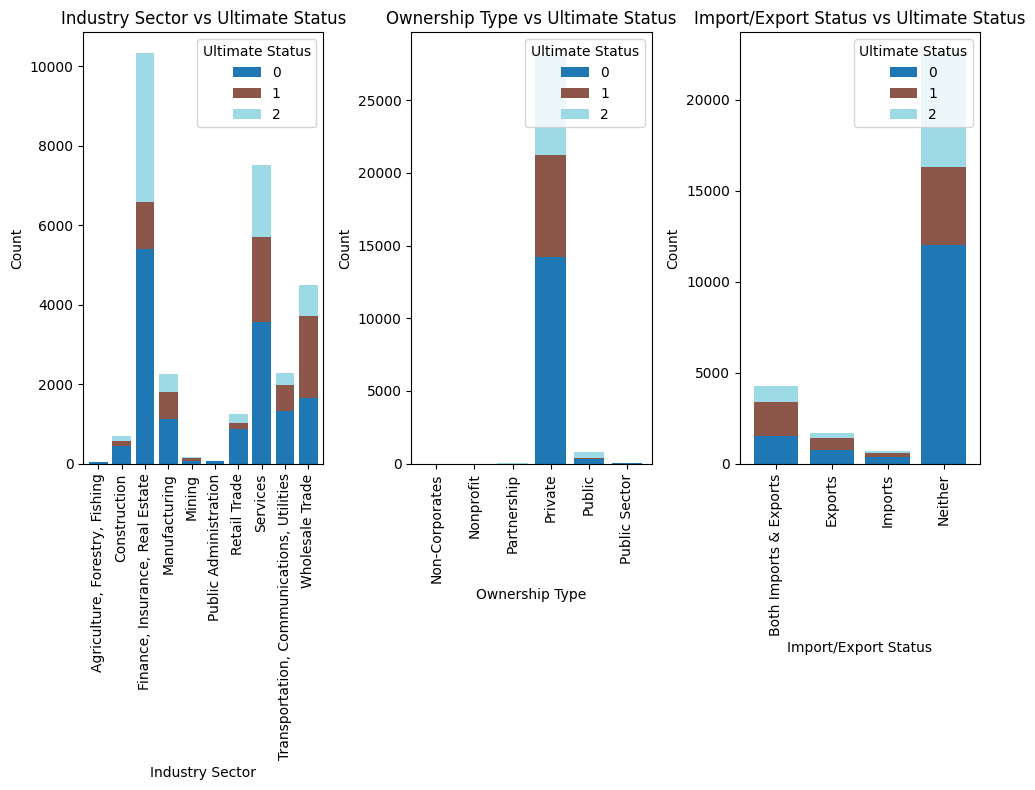

In [ ]:
# Define categorical columns
categorical_cols = ["Industry Sector", "Ownership Type", "Import/Export Status"]

# Create subplots (stacked vertically)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

# Plot stacked bar chart for each categorical column split by 'Ultimate_Status'
for i, col in enumerate(categorical_cols):
    # Calculate the counts of each Ultimate_Status class per category
    count_data = pd.crosstab(data_clean[col], data_clean['Ultimate_Status'])

    # Plot stacked bar chart with absolute counts and better contrasting colors
    count_data.plot(kind='bar', stacked=True, ax=axes[i], colormap="tab20", width=0.8)

    axes[i].set_title(f"{col} vs Ultimate Status")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].legend(title='Ultimate Status', loc='upper right', labels=['0', '1', '2'])

plt.tight_layout()
plt.show()

In [ ]:
# Reducing cardinality by binning infrequent classes into "Others"
valid_industry_sectors = [
    "Construction",
    "Finance, Insurance, Real Estate",
    "Manufacturing",
    "Retail Trade",
    "Services",
    "Transportation, Communications, Utilities",
    "Wholesale Trade"
]

data_clean['Industry Sector'] = data_clean['Industry Sector'].apply(
    lambda x: x if x in valid_industry_sectors else 'Others'
)

data_clean['Ownership Type'] = data_clean['Ownership Type'].apply(lambda x: 'Private' if x == 'Private' else 'Non-Private')

## 2F. Removal of Redundant Columns

In [ ]:
# Removing columns that are redundant after cleaning
data_clean.drop(columns = columns_dropped + columns_converted, axis=1, inplace=True)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29179 entries, 0 to 29181
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Ownership Type                       29179 non-null  object 
 1   Employees (Single Site)              29179 non-null  float64
 2   Employees (Domestic Ultimate Total)  29179 non-null  float64
 3   Employees (Global Ultimate Total)    29179 non-null  float64
 4   Sales (Domestic Ultimate Total USD)  29179 non-null  int64  
 5   Sales (Global Ultimate Total USD)    29179 non-null  int64  
 6   Import/Export Status                 29179 non-null  object 
 7   Ultimate_Status                      29179 non-null  int64  
 8   missing_single_employees             29179 non-null  int64  
 9   missing_global_employees             29179 non-null  int64  
 10  Company Age                          29179 non-null  int32  
 11  Industry Sector                  

## 2G. Handling Duplicated Values
After applying our data cleaning and transformation strategies, we identified 6761 duplicated rows in the dataset. This occurred after removing unique identifiers (such as `AccountID` and `Company`), which suggests that certain records were structurally similar but previously distinguished by these unique attributes.

Instead of removing these duplicates outright, we analyzed the distribution of the target variable (`Ultimate_Status`) within them. Our analysis revealed that the distribution of Ultimate_Status was not uniform, indicating that these records may still carry useful patterns for classification rather than representing pure redundancy.

To preserve class balance and prevent potential information loss, we opted to retain these duplicates rather than arbitrarily removing them. This ensures that our model is exposed to the full range of patterns present in the dataset, which could contribute to more robust predictions.

In [ ]:
# Subset data_clean for duplicated rows
duplicated_data_clean = data_clean[data_clean.duplicated()]
ultimate_status_counts = duplicated_data_clean["Ultimate_Status"].value_counts(normalize=True)

# Display the counts
print(f"Number of Duplicates Before Cleaning: {data.duplicated().sum()}")
print(f"Number of Duplicates After Cleaning: {data_clean.duplicated().sum()}")
print("Proportion of Ultimate Status in Duplicated Rows:")
print(ultimate_status_counts)

Number of Duplicates Before Cleaning: 0
Number of Duplicates After Cleaning: 6761
Proportion of Ultimate Status in Duplicated Rows:
Ultimate_Status
2    0.506138
0    0.477148
1    0.016714
Name: proportion, dtype: float64


Additionally, we observed that a large portion of our dataset had identical domestic and global employee/sales counts. Interestingly, almost none of these companies were labeled as Domestic Ultimates, suggesting that they are more likely owned by Global Ultimates. While we lack domain expertise to confirm this, this insight could help future models differentiate between Domestic and Global Ultimates more effectively.

To capture this pattern, we engineered a new feature, SameSalesEmployees, which flags companies where domestic and global sales and employee counts are identical. This feature may help our model learn structural distinctions between Domestic and Global Ultimates, potentially improving classification accuracy.

In [ ]:
# Number of Companies with Identical Employees & Sales globally vs domestically
data_dupe = data_clean[
    (data_clean["Employees (Domestic Ultimate Total)"] == data_clean["Employees (Global Ultimate Total)"]) &
    (data_clean["Sales (Domestic Ultimate Total USD)"] == data_clean["Sales (Global Ultimate Total USD)"])
]

print(f"Number of rows where either Employees or Sales counts are identical: {len(data_dupe)}")
print("\nProportion of Ultimate Status for Companies with Duplicated Employees & Sales:")
print(data_dupe["Ultimate_Status"].value_counts(normalize=True))

Number of rows where either Employees or Sales counts are identical: 19554

Proportion of Ultimate Status for Companies with Duplicated Employees & Sales:
Ultimate_Status
0    0.627493
2    0.371280
1    0.001227
Name: proportion, dtype: float64


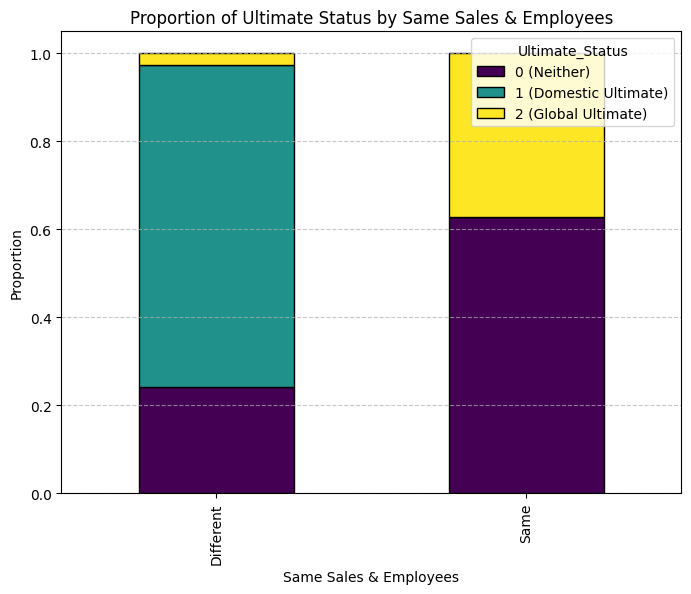

In [ ]:
# Creating a feature that flags identical sales & employee counts
data_clean["SameSalesEmployees"] = (
    (data_clean["Employees (Domestic Ultimate Total)"] == data_clean["Employees (Global Ultimate Total)"]) &
    (data_clean["Sales (Domestic Ultimate Total USD)"] == data_clean["Sales (Global Ultimate Total USD)"])
).astype(int)

# Group by "SameSalesEmployees" and count occurrences of each "Ultimate Status"
SameSalesEmployees_status_counts = data_clean.groupby("SameSalesEmployees")["Ultimate_Status"].value_counts(normalize=True).unstack()

# Plot the stacked bar graph
SameSalesEmployees_status_counts.plot(kind="bar", stacked=True, colormap="viridis", edgecolor="black", figsize=(8, 6))

# Formatting
plt.xlabel("Same Sales & Employees")
plt.ylabel("Proportion")
plt.title("Proportion of Ultimate Status by Same Sales & Employees")
plt.legend(title="Ultimate_Status", labels=["0 (Neither)", "1 (Domestic Ultimate)", "2 (Global Ultimate)"])
plt.xticks(ticks=[0, 1], labels=["Different", "Same"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# SECTION 3: FEATURE ENGINEERING

In [ ]:
data_transform = data_clean.copy()

## 3A: Addition of Variables
We summed each company's sales and employees into `Total_Sales` and `Total_Employees` to capture overall company scale. We found that Domestic Ultimates have the highest median sales and employees. This could help our future models take advantage of these variables to improve classification.

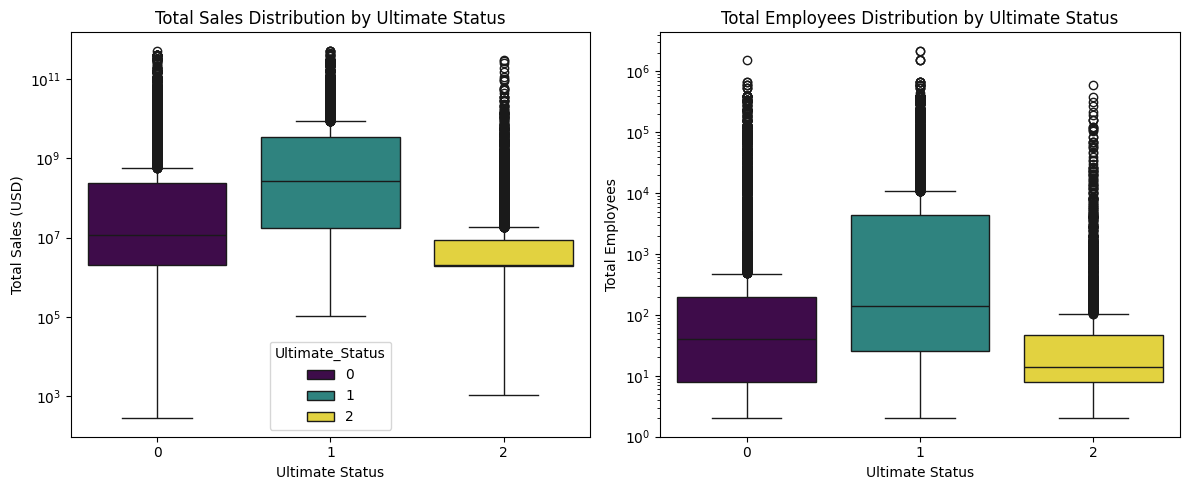

In [ ]:
# Creating Addition Variables
data_transform["Total_Sales"] = data_transform["Sales (Domestic Ultimate Total USD)"] + data_transform["Sales (Global Ultimate Total USD)"] + data_transform["Employees (Single Site)"]
data_transform["Total_Employees"] = data_transform["Employees (Domestic Ultimate Total)"] + data_transform["Employees (Global Ultimate Total)"]

# Plot boxplots split by Ultimate_Status
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for Total Sales
sns.boxplot(x=data_transform["Ultimate_Status"], y=data_transform["Total_Sales"], data=data_transform, hue="Ultimate_Status", ax=axes[0], palette="viridis")
axes[0].set_title("Total Sales Distribution by Ultimate Status")
axes[0].set_xlabel("Ultimate Status")
axes[0].set_ylabel("Total Sales (USD)")
axes[0].set_yscale("log")  # Log scale to handle skewness

# Boxplot for Total Employees
sns.boxplot(x="Ultimate_Status", y="Total_Employees", data=data_transform, hue="Ultimate_Status", palette="viridis", ax=axes[1], legend=False)
axes[1].set_title("Total Employees Distribution by Ultimate Status")
axes[1].set_xlabel("Ultimate Status")
axes[1].set_ylabel("Total Employees")
axes[1].set_yscale("log")  # Log scale to handle skewness

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

## 3B: Ratios of Variables
To enhance predictive power, we engineered ratio-based features that capture relative relationships between sales, employees, company age, and growth patterns. These transformations provided a more scale-invariant representation of company characteristics, helping the model generalize better across companies of different sizes.

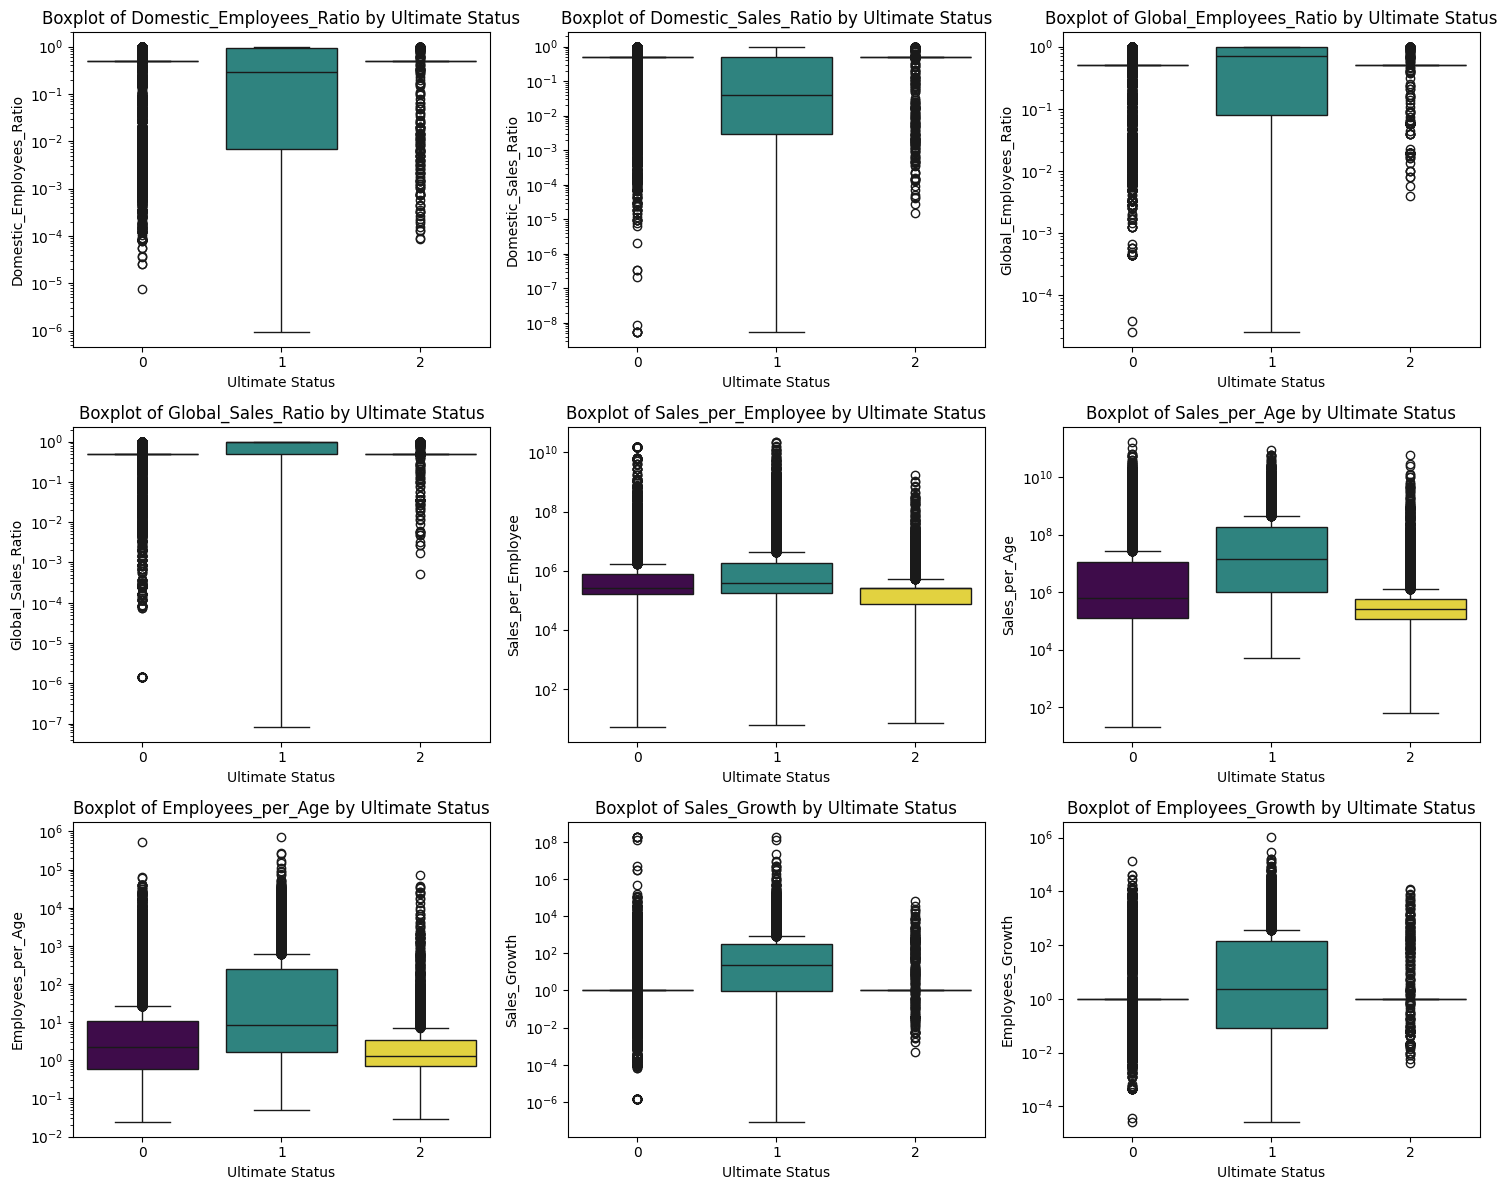

In [ ]:
# Create ratio-based features
data_transform["Domestic_Employees_Ratio"] = data_transform["Employees (Domestic Ultimate Total)"] / data_transform["Total_Employees"]
data_transform["Domestic_Sales_Ratio"] = data_transform["Sales (Domestic Ultimate Total USD)"] / data_transform["Total_Sales"]
data_transform["Global_Employees_Ratio"] = data_transform["Employees (Global Ultimate Total)"] / data_transform["Total_Employees"]
data_transform["Global_Sales_Ratio"] = data_transform["Sales (Global Ultimate Total USD)"] / data_transform["Total_Sales"]
data_transform["Sales_per_Employee"] = data_transform["Total_Sales"] / data_transform["Total_Employees"]
data_transform["Sales_per_Age"] = data_transform["Total_Sales"] / (data_transform["Company Age"])
data_transform["Employees_per_Age"] = data_transform["Total_Employees"] / (data_transform["Company Age"])
data_transform["Sales_Growth"] = data_transform["Sales (Global Ultimate Total USD)"] / data_transform["Sales (Domestic Ultimate Total USD)"]
data_transform["Employees_Growth"] = data_transform["Employees (Global Ultimate Total)"] / data_transform["Employees (Domestic Ultimate Total)"]


# Define all transformation features
ratio_features = [
    "Domestic_Employees_Ratio",
    "Domestic_Sales_Ratio",
    "Global_Employees_Ratio",
    "Global_Sales_Ratio",
    "Sales_per_Employee",
    "Sales_per_Age",
    "Employees_per_Age",
    "Sales_Growth",
    "Employees_Growth"
]

# Create boxplots for transformation features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(ratio_features):
    sns.boxplot(x="Ultimate_Status", y=var, data=data_transform, hue="Ultimate_Status", palette="viridis", ax=axes[i], legend=False)
    axes[i].set_title(f"Boxplot of {var} by Ultimate Status")
    axes[i].set_xlabel("Ultimate Status")
    axes[i].set_ylabel(var)
    axes[i].set_yscale("log")  # Log scale to handle skewness

plt.tight_layout()
plt.show()


In [ ]:
data_transform.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29179 entries, 0 to 29181
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Ownership Type                       29179 non-null  object 
 1   Employees (Single Site)              29179 non-null  float64
 2   Employees (Domestic Ultimate Total)  29179 non-null  float64
 3   Employees (Global Ultimate Total)    29179 non-null  float64
 4   Sales (Domestic Ultimate Total USD)  29179 non-null  int64  
 5   Sales (Global Ultimate Total USD)    29179 non-null  int64  
 6   Import/Export Status                 29179 non-null  object 
 7   Ultimate_Status                      29179 non-null  int64  
 8   missing_single_employees             29179 non-null  int64  
 9   missing_global_employees             29179 non-null  int64  
 10  Company Age                          29179 non-null  int32  
 11  Industry Sector                  

# SECTION 4: MODEL DEVELOPMENT

In [ ]:
data_ml =  data_transform.copy()

## 4A. Encoding Categorical Variables

To incorporate categorical features into the model, we apply One-Hot Encoding to the categorical variables `Ownership Type`, `Industry Sector`, `Import/Export Status`, allowing machine learning models to interpret them as numerical data.

In [ ]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Select categorical columns
cat_cols = ["Ownership Type", "Industry Sector", "Import/Export Status"]

# Fit and transform categorical data
encoded_array = encoder.fit_transform(data_ml[cat_cols])

# Convert the result to a DataFrame with meaningful column names
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols), index=data_ml.index)

# Concatenate encoded columns to original DataFrame
data_ml = pd.concat([data_ml, encoded_df], axis=1)

# Drop the original categorical columns
data_ml.drop(columns=cat_cols, inplace=True)

# Print the transformed data to verify new columns
print(data_ml.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29179 entries, 0 to 29181
Data columns (total 35 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Employees (Single Site)                                    29179 non-null  float64
 1   Employees (Domestic Ultimate Total)                        29179 non-null  float64
 2   Employees (Global Ultimate Total)                          29179 non-null  float64
 3   Sales (Domestic Ultimate Total USD)                        29179 non-null  int64  
 4   Sales (Global Ultimate Total USD)                          29179 non-null  int64  
 5   Ultimate_Status                                            29179 non-null  int64  
 6   missing_single_employees                                   29179 non-null  int64  
 7   missing_global_employees                                   29179 non-null  int64  
 8   Company Age

## 4B. Train-Test Split, SMOTE, and Feature Scaling

- We split the data into 80% training and 20% testing as instucted while maintaining class balance using stratification.
- We applied SMOTE (Synthetic Minority Over-sampling Technique) on the training set to address the slight class imbalance.
- For feature scaling, we fitted a StandardScaler on the training set and used the same mean and standard deviation to transform the test set, preventing data leakage.
- Finally, we prepared a **5-fold Stratified Cross-Validation** to evaluate model performance across different data splits.

In [ ]:
# Train-Test Split (80%-20%)
X = data_ml.drop(columns=["Ultimate_Status"])
y = data_ml["Ultimate_Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on the training set (before scaling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()

# Fit scaler on the training data only and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train_smote)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#  Prepare 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4C. Recursive Feature Elimination
We applied Recursive Feature Elimination using a model with default parameters to systematically remove the least important features from our 30+ feature set. At each step, we evaluated the cross-validated F1 score and plotted the results to visualize performance trends. Using the elbow method, we identified the optimal number of features where additional removals provided diminishing returns. The chosen 15 features were stored in `selected_features` for downstream modeling. To improve efficiency and avoid long run times, the RFE implementation has been commented out in the final notebook.

In [ ]:
# # Initialize XGBoost model with default parameters for multiclass classification
# xgb_model = XGBClassifier(objective="multi:softmax")

# # Define F1-score as the evaluation metric
# f1_scorer = make_scorer(f1_score, average="weighted")  # Weighted for multiclass classification

# # Perform Recursive Feature Elimination with Cross-Validation (RFECV)
# rfecv = RFECV(estimator=xgb_model, step=1, cv=5, scoring=f1_scorer, n_jobs=-1)
# rfecv.fit(X_train_scaled, y_train_smote)

# # Get the optimal number of features
# optimal_features = sum(rfecv.support_)
# print(f"Optimal number of features: {optimal_features}")

# # Selected features
# selected_features = X_train_scaled.columns[rfecv.support_]

# # Plot F1 Score vs. Number of Features
# plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
# plt.xlabel("Number of Features Selected")
# plt.ylabel("Cross-Validated F1 Score")
# plt.title("Optimal Number of Features Selection (F1 Score)")
# plt.show()

In [ ]:
# Manually storing top 15 features after RFE
selected_features = ['Employees (Single Site)',
                     'Employees (Domestic Ultimate Total)',
                     'missing_single_employees',
                     'SameSalesEmployees',
                     'Domestic_Employees_Ratio',
                     'Domestic_Sales_Ratio',
                     'Global_Sales_Ratio',
                     'Employees_Growth',
                     'Ownership Type_Non-Private',
                     'Ownership Type_Private',
                     'Industry Sector_Finance, Insurance, Real Estate',
                     'Industry Sector_Manufacturing',
                     'Industry Sector_Services',
                     'Import/Export Status_Both Imports & Exports',
                     'Import/Export Status_Neither']

# Reduce dataset to selected features
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

## 4D. Hyperparameter Tuning
To balance computational efficiency and model performance, we designed a smaller parameter grid for hyperparameter tuning, considering time constraints and resource limitations. Using GridSearchCV with 5-fold cross-validation, we optimized key parameters such as learning rate, tree depth, and subsampling rates. The best-performing parameters were stored in `best_params` and are now used directly in model training. To prevent unnecessary re-computation, the hyperparameter tuning code has been commented out in the final notebook.

In [ ]:
# # Define parameter grid for tuning (balanced between performance & runtime)
# param_grid = {
#     "n_estimators": [75, 100, 150],  # Number of boosting rounds
#     "learning_rate": [0.1],  # Step size shrinkage
#     "max_depth": [3, 5, 7, 10],  # Depth of trees (lower for speed, higher for complexity)
#     "subsample": [0.5, 0.7, 0.9],  # Fraction of training samples per tree
#     "colsample_bytree": [0.5, 0.7, 0.9],  # Fraction of features per tree
#     "eval_metric": ["mlogloss"]  # Evaluation metric

# }

# # Initialize XGBoost classifier
# xgb_model = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)

# # Define 5-fold Stratified CV
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Define F1-score as the evaluation metric
# f1_scorer = make_scorer(f1_score, average="weighted")

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=1
# )

# # Fit GridSearchCV on the selected features
# grid_search.fit(X_train_selected, y_train_smote)

# # Print the best parameters and best score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best F1 Score: {grid_search.best_score_:.4f}")


## 4E. Final Model
Our final XGBoost model, trained with the optimized hyperparameters and selected features, achieved strong performance on the test set, with an average accuracy of 91.45% and a weighted F1-score of 91.48%. The classification report shows that all three classes are well-predicted with minimal misclasification. The model effectively differentiates between corporate ownership types in unseen data, demonstrating its suitability for real-world application.

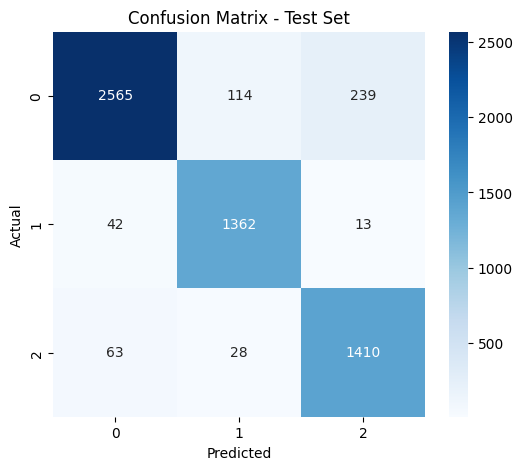

Classification Report - Test Set:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      2918
           1       0.91      0.96      0.93      1417
           2       0.85      0.94      0.89      1501

    accuracy                           0.91      5836
   macro avg       0.90      0.93      0.91      5836
weighted avg       0.92      0.91      0.91      5836

XGBoost Test Accuracy: 0.9145
XGBoost Test F1 Score: 0.9148


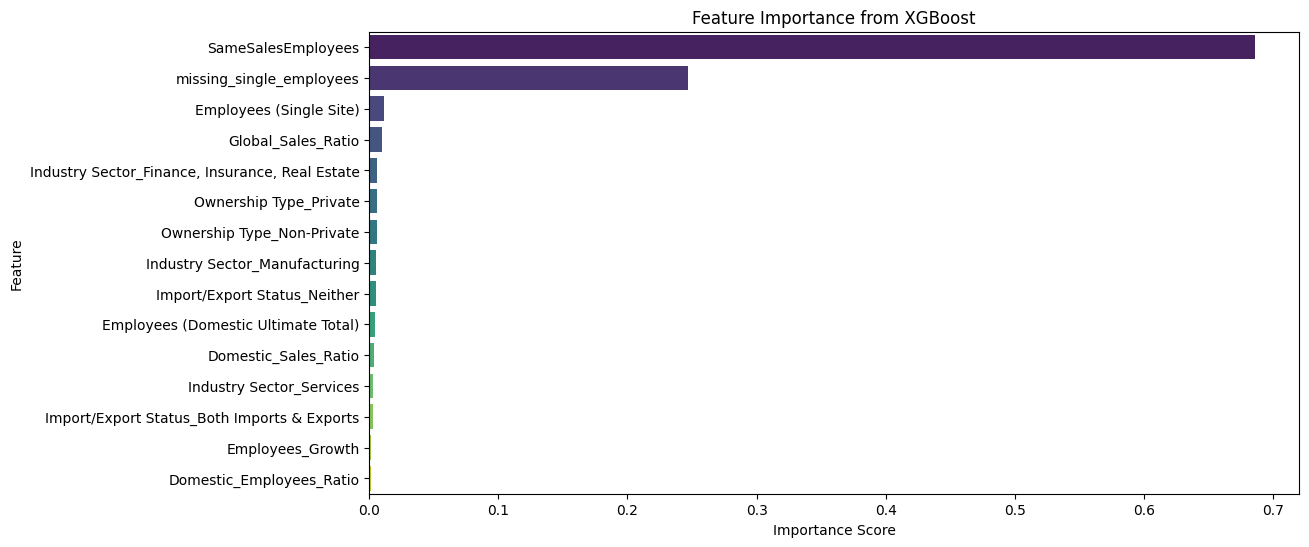

In [ ]:
# Best parameters after hyperparameter tuning
best_params = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.1,
    "max_depth": 10,
    "n_estimators": 100,
    "subsample": 0.9
}

# Initialize XGBoost model with best parameters
xgb_model = XGBClassifier(
    **best_params,  # Use optimized hyperparameters
    objective="multi:softmax",
    num_class=3,
    random_state=42
)

# Train the model on selected features
xgb_model.fit(X_train_selected, y_train_smote)

# Make predictions on test set
y_pred_test = xgb_model.predict(X_test_selected)

# Compute accuracy and F1 score for test set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average="weighted")  # Weighted for multi-class

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report & Results
print("Classification Report - Test Set:\n", classification_report(y_test, y_pred_test))
print(f"XGBoost Test Accuracy: {accuracy_test:.4f}")
print(f"XGBoost Test F1 Score: {f1_test:.4f}")

# Feature Importance
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({"Feature": selected_features, "Importance": feature_importance}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", hue="Feature", data=importance_df, palette="viridis", legend=False)
plt.title("Feature Importance from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()